```
This software is part of GPU Ocean. 

Copyright (C) 2022, 2023 SINTEF Digital

Investigating the effect of different flux formulations and slope
limiters for real-world oceanographic simulations

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Tuning CDKLM for improved real-world simulations

This notebook runs several ocean simulations around the Lofoten archipelago with different parameters for flux balance and slope limiters.
The goal is to find a new optimal set of parameters for future experiments.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from netCDF4 import Dataset
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
plt.rcParams["animation.html"] = "jshtml"
mpl.rcParams['figure.facecolor'] = 'white'
plt.rcParams['text.usetex'] = True


In [2]:
from gpuocean.SWEsimulators import CDKLM16, KP07
from gpuocean.utils import Common, IPythonMagic, NetCDFInitialization, PlotHelper
from gpuocean.drifters import GPUDrifterCollection

In [3]:
%cuda_context_handler gpu_ctx

### Plotting functionality

In [4]:
def plotSolution(fig, sim, comment="",
                 eta_max=2, hu_max=50, 
                 ax=None, sp=None):

    eta, hu, hv = sim.download(interior_domain_only=True)
    dx, dy, t = sim.dx, sim.dy, sim.t
    
    from datetime import timedelta
    fig.suptitle("Time = {:0>8} ({:s})".format(str(timedelta(seconds=int(t))), comment), 
                 fontsize=18,
                 horizontalalignment='left')
    
    ny, nx = eta.shape
    domain_extent = [0, nx*dx, 0, ny*dy]
   
    if (ax is None):
        ax = [None]*3
        sp = [None]*3
        
        ax[0] = plt.subplot(1, 3, 1)
        sp[0] = ax[0].imshow(eta, interpolation="none", origin='lower', 
                             cmap=plt.cm.BrBG, vmin=-eta_max, vmax=eta_max, 
                             extent=domain_extent)
        plt.colorbar(sp[0], shrink=0.9)
        plt.axis('image')
        plt.title("$\eta{}$")
        
        ax[1] = plt.subplot(1, 3, 2)
        sp[1] = ax[1].imshow(hu, interpolation="none", origin='lower', 
                            cmap=plt.cm.coolwarm, vmin=-hu_max, vmax=hu_max, 
                            extent=domain_extent)
        plt.colorbar(sp[1], shrink=0.9)
        plt.axis('image')
        plt.title("$hu$")

        ax[2] = plt.subplot(1, 3, 3)
        sp[2] = ax[2].imshow(hv, interpolation="none", origin='lower', 
                             cmap=plt.cm.coolwarm, vmin=-hu_max, vmax=hu_max, 
                             extent=domain_extent)
        plt.colorbar(sp[2], shrink=0.9)
        plt.axis('image')
        plt.title("$hv$")
            
    else:        
        #Update plots
        fig.sca(ax[0])
        sp[0].set_data(eta)
        
        fig.sca(ax[1])
        sp[1].set_data(hu)
        
        fig.sca(ax[2])
        sp[2].set_data(hv)
        
    return ax, sp


def sim_animation(sim, T, anim_dt, hu_max=20.0, eta_max=0.5, comment=""):
    """
    Creates an animation of the simulator based on T frames, with frames sub_dt*sim.dt appart.
    """

    
    #Create figure and plot initial conditions
    fig = plt.figure(figsize=(14, 4))
    ax, sp = plotSolution(fig, sim, comment=comment,
                          eta_max=eta_max, hu_max=hu_max)
    #Helper function which simulates and plots the solution
    def animate(i):
        if (i>0):
            t = sim.step(anim_dt)
        else:
            t = 0.0

        plotSolution(fig, sim, comment=comment, ax=ax, sp=sp)
        print(".", end='')
        
    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(T), interval=100)
    plt.close(fig)
    return anim

In [5]:
def plotCrossection(sims, labels, x=None, y=None):
    numSections = 0
    if x is not None:
        numSections = numSections + 1
    if y is not None:
        numSections = numSections + 1
    assert(numSections == 1), "provide one and only one of x or y"
   

    fig = plt.figure(figsize=(10, 7))
    ax = [None]*3
    sp = [None]*3
    ax[0] = plt.subplot(3, 1, 1)
    ax[1] = plt.subplot(3, 1, 2)
    ax[2] = plt.subplot(3, 1, 3)
    for i in range(len(sims)):
        eta, hu, hv = sims[i].download(interior_domain_only=True)
        #_, Hm = sims[i].downloadBathymetry(interior_domain_only=True)
        #hu = hu/(eta+Hm)
        if x is not None:
            ax[0].plot(eta[:, x], label=labels[i])
            ax[1].plot( hu[:, x], label=labels[i])
            ax[2].plot( hv[:, x], label=labels[i])
        else:
            ax[0].plot(eta[y, :], label=labels[i])
            ax[1].plot( hu[y, :], label=labels[i])
            ax[2].plot( hv[y, :], label=labels[i])
    ax[0].legend()
    ax[0].set_title("eta")
    ax[1].set_title("hu")
    ax[2].set_title("hv")
    if x is not None:
        plt.suptitle("Cross section at x = " + str(x))
    else:
        plt.suptitle("Cross section at y = " + str(y))
        

# Select url for initial conditions, domain, and simulate!

In [6]:
source_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

casename = 'lofoten'

case_info = NetCDFInitialization.getCaseLocation(casename)
print(case_info["name"])

data_args = NetCDFInitialization.getInitialConditions(source_url,case_info["x0"], case_info["x1"], case_info["y0"], case_info["y1"], download_data=False, erode_land=0)

lofoten


In [7]:

try:
    ncfile = Dataset(source_url)
    H_full = np.array(ncfile.variables['h'])
    angle = np.array(ncfile.variables['angle'])
    print(H_full.shape)
    lat = np.array(ncfile.variables["lat"])
    lon = np.array(ncfile.variables["lon"])
except Exception as e:
    raise e

finally:
    ncfile.close()

spec_lat = lat[case_info["y0"]:case_info["y1"], case_info["x0"]:case_info["x1"]]
spec_lon = lon[case_info["y0"]:case_info["y1"], case_info["x0"]:case_info["x1"]]


(902, 2602)


CDKLM standard upwind, $\theta=1.3$

In [8]:
if "sim_su_theta13" in globals():
    sim_su_theta13.cleanUp()
    
sim_su_theta13 = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, write_netcdf=False,  **NetCDFInitialization.removeMetadata(data_args), flux_balancer=1.0, theta=1.3)
sim_su_theta13.step(23*3600)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


82800.0

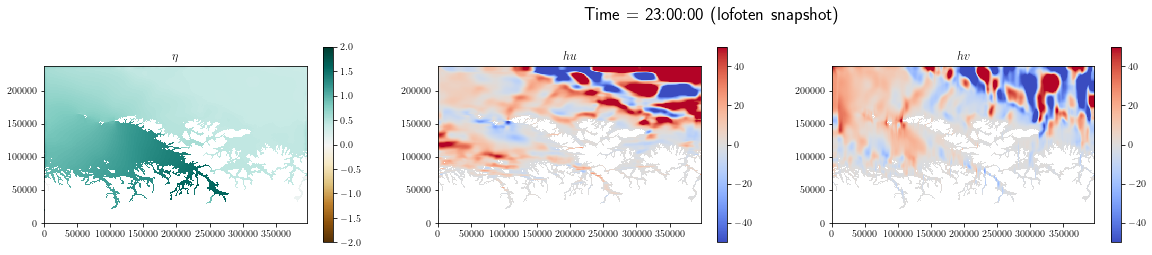

In [9]:
fig = plt.figure(figsize=(20,4))
_, _ = plotSolution(fig, sim_su_theta13, hu_max=50.0, eta_max=2, comment=case_info["name"]+" snapshot")


CDKLM central upwind ($\theta = 1.3$)

In [10]:
if "sim_cu_theta13" in globals():
    sim_cu_theta13.cleanUp()
    
sim_cu_theta13 = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, write_netcdf=False,  **NetCDFInitialization.removeMetadata(data_args), flux_balancer=0.0, theta=1.3)
sim_cu_theta13.step(23*3600)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


82800.0

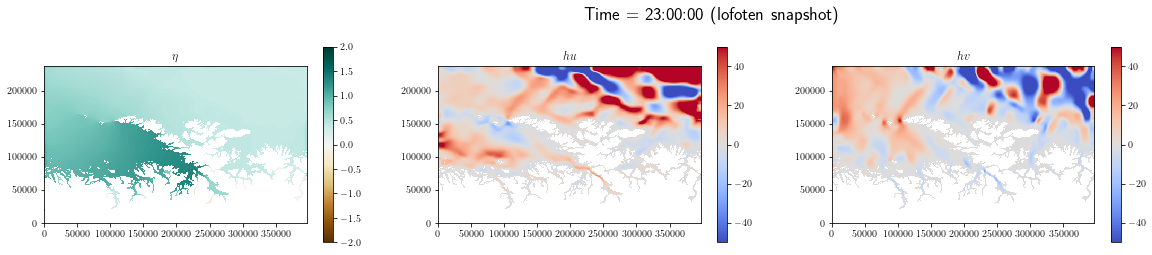

In [11]:
fig = plt.figure(figsize=(20,4))
_, _ = plotSolution(fig, sim_cu_theta13, hu_max=50.0, eta_max=2, comment=case_info["name"]+" snapshot")

CDKLM central upwind ($\theta = 2.0$)

In [12]:
if "sim_cu_theta2" in globals():
    sim_cu_theta2.cleanUp()
    
sim_cu_theta2 = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, write_netcdf=False,  **NetCDFInitialization.removeMetadata(data_args), flux_balancer=0.0, theta=2.0)
sim_cu_theta2.step(23*3600)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


82800.0

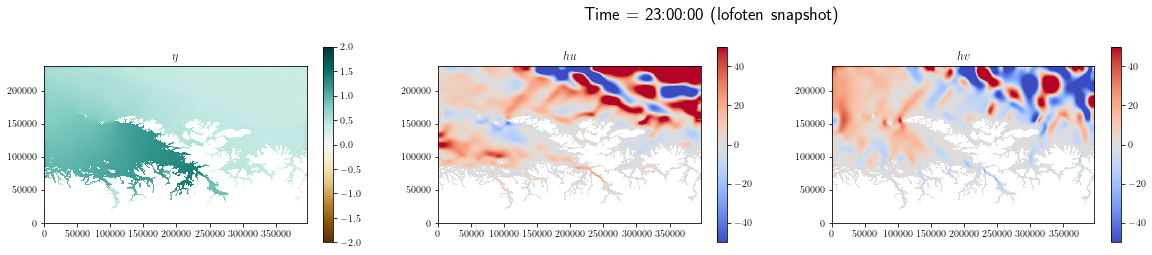

In [13]:
fig = plt.figure(figsize=(20,4))
_, _ = plotSolution(fig, sim_cu_theta2, hu_max=50.0, eta_max=2, comment=case_info["name"]+" snapshot")

CDKLM central upwind ($\theta = 1.0$)

In [14]:
if "sim_cu_theta1" in globals():
    sim_cu_theta1.cleanUp()
    
sim_cu_theta1 = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, write_netcdf=False,  **NetCDFInitialization.removeMetadata(data_args), flux_balancer=0.0, theta=1.0)
sim_cu_theta1.step(23*3600)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


82800.0

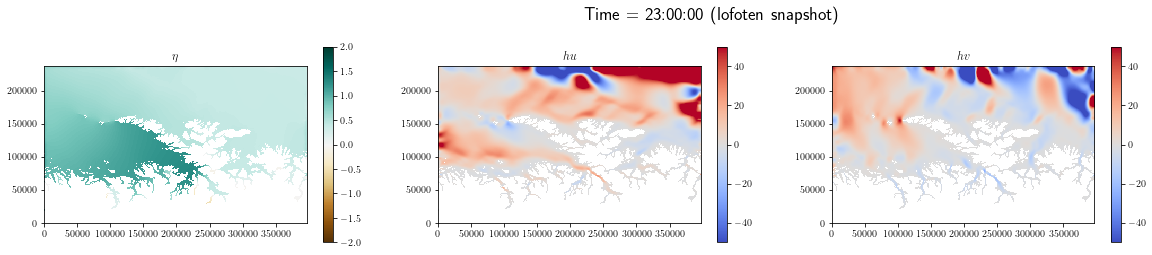

In [15]:
fig = plt.figure(figsize=(20,4))
_, _ = plotSolution(fig, sim_cu_theta1, hu_max=50.0, eta_max=2, comment=case_info["name"]+" snapshot")

CDKLM central upwind ($\theta = 1.8$)

In [16]:
if "sim_cu_theta18" in globals():
    sim_cu_theta18.cleanUp()
    
sim_cu_theta18 = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, write_netcdf=False,  **NetCDFInitialization.removeMetadata(data_args), flux_balancer=0.0, theta=1.8)
sim_cu_theta18.step(23*3600)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


82800.0

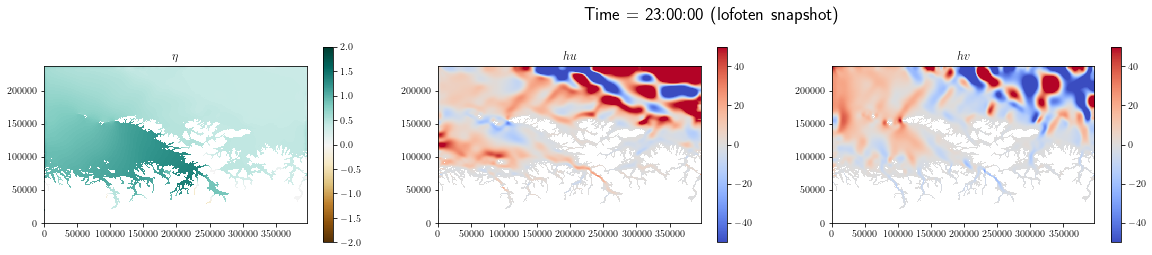

In [17]:
fig = plt.figure(figsize=(20,4))
_, _ = plotSolution(fig, sim_cu_theta18, hu_max=50.0, eta_max=2, comment=case_info["name"]+" snapshot")

CDKLM standard upwind, $\theta=2$

In [18]:
if "sim_su_theta2" in globals():
    sim_su_theta2.cleanUp()
    
sim_su_theta2 = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, write_netcdf=False,  **NetCDFInitialization.removeMetadata(data_args), flux_balancer=1.0, theta=2)
sim_su_theta2.step(23*3600)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


82800.0

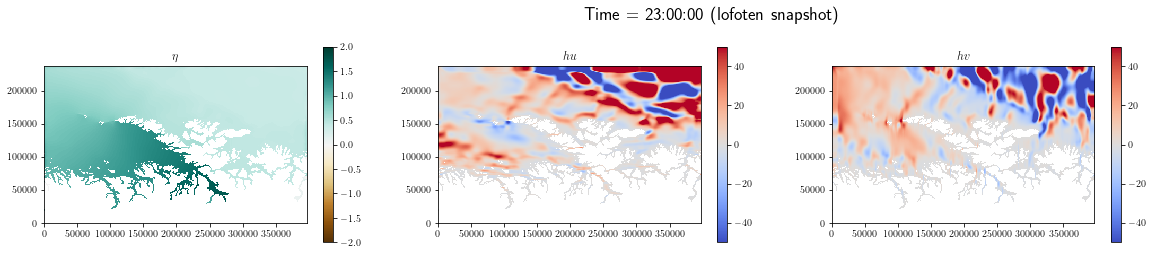

In [19]:
fig = plt.figure(figsize=(20,4))
_, _ = plotSolution(fig, sim_su_theta2, hu_max=50.0, eta_max=2, comment=case_info["name"]+" snapshot")


CDKLM standard upwind, $\theta=1.8$

In [20]:
if "sim_su_theta18" in globals():
    sim_su_theta18.cleanUp()
    
sim_su_theta18 = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, write_netcdf=False,  **NetCDFInitialization.removeMetadata(data_args), flux_balancer=1.0, theta=1.8)
sim_su_theta18.step(23*3600)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


82800.0

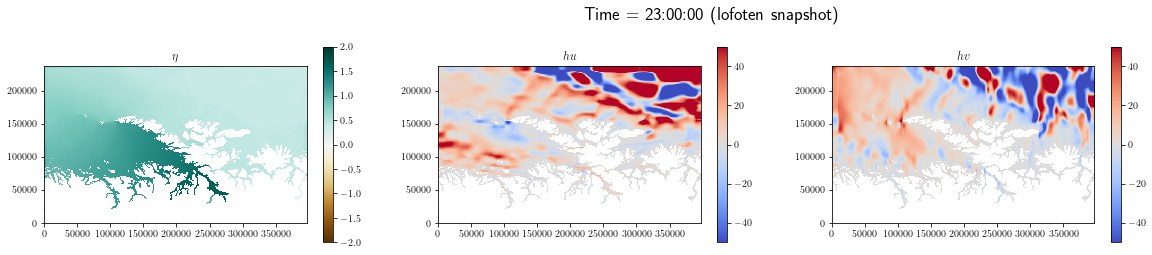

In [21]:
fig = plt.figure(figsize=(20,4))
_, _ = plotSolution(fig, sim_su_theta18, hu_max=50.0, eta_max=2, comment=case_info["name"]+" snapshot")


CDKLM $\phi=0.9$, $\theta=1.8$

In [22]:
if "sim_phi09_theta18" in globals():
    sim_phi09_theta18.cleanUp()
    
sim_phi09_theta18 = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, write_netcdf=False,  **NetCDFInitialization.removeMetadata(data_args), flux_balancer=0.9, theta=1.8)
sim_phi09_theta18.step(23*3600)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


82800.0

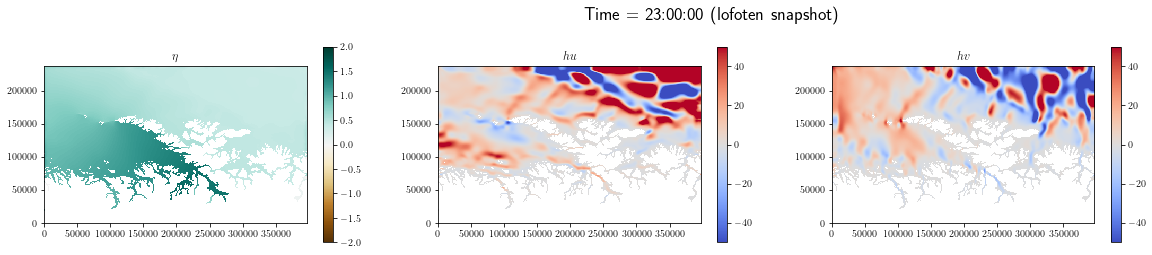

In [23]:
fig = plt.figure(figsize=(20,4))
_, _ = plotSolution(fig, sim_phi09_theta18, hu_max=50.0, eta_max=2, comment=case_info["name"]+" snapshot")


CDKLM $\phi=0.8$, $\theta=1.8$

In [24]:
if "sim_phi08_theta18" in globals():
    sim_phi08_theta18.cleanUp()
    
sim_phi08_theta18 = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, write_netcdf=False,  **NetCDFInitialization.removeMetadata(data_args), flux_balancer=0.8, theta=1.8)
sim_phi08_theta18.step(23*3600)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


82800.0

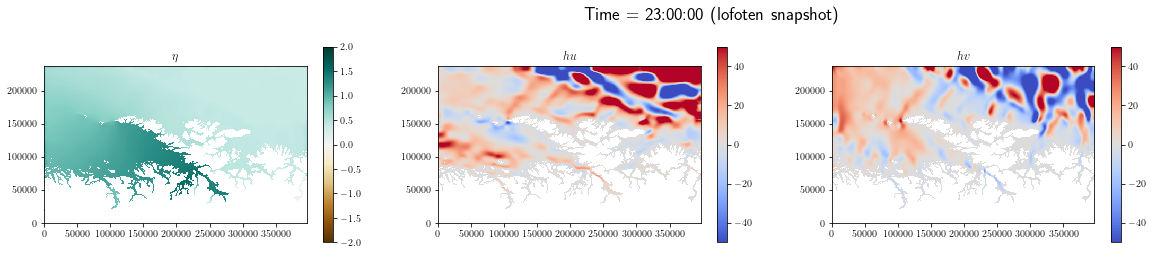

In [25]:
fig = plt.figure(figsize=(20,4))
_, _ = plotSolution(fig, sim_phi08_theta18, hu_max=50.0, eta_max=2, comment=case_info["name"]+" snapshot")


CDKLM $\phi=0.5$, $\theta=1.8$

In [26]:
if "sim_phi05_theta18" in globals():
    sim_phi05_theta18.cleanUp()
    
sim_phi05_theta18 = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, write_netcdf=False,  **NetCDFInitialization.removeMetadata(data_args), flux_balancer=0.5, theta=1.8)
sim_phi05_theta18.step(23*3600)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


82800.0

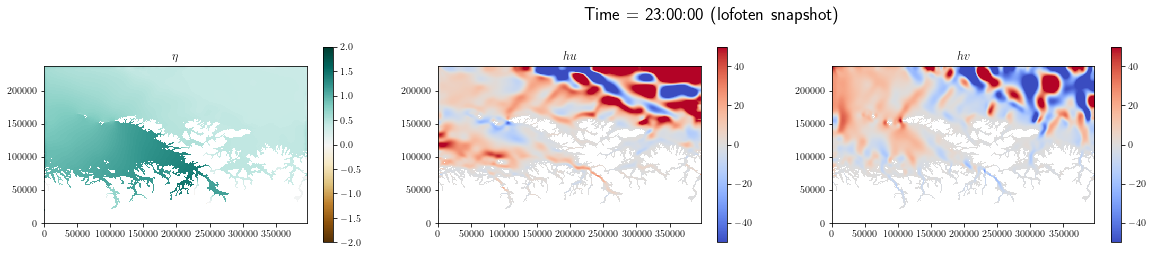

In [27]:
fig = plt.figure(figsize=(20,4))
_, _ = plotSolution(fig, sim_phi05_theta18, hu_max=50.0, eta_max=2, comment=case_info["name"]+" snapshot")


CDKLM $\phi=0.9$, $\theta=2$

In [28]:
if "sim_phi09_theta2" in globals():
    sim_phi09_theta2.cleanUp()
    
sim_phi09_theta2 = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, write_netcdf=False,  **NetCDFInitialization.removeMetadata(data_args), flux_balancer=0.9, theta=2.0)
sim_phi09_theta2.step(23*3600)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


82800.0

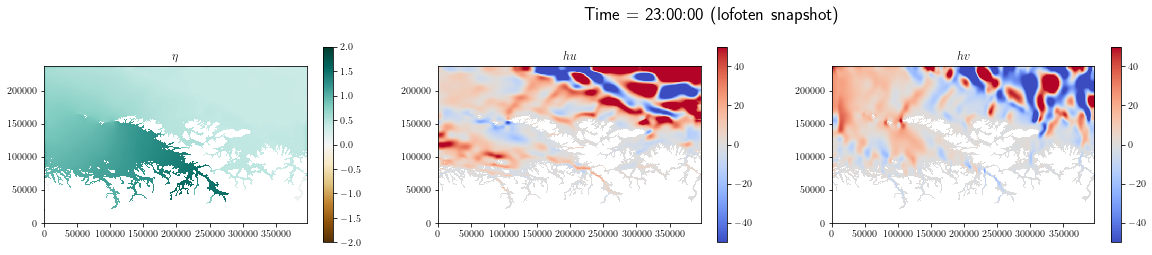

In [29]:
fig = plt.figure(figsize=(20,4))
_, _ = plotSolution(fig, sim_phi09_theta2, hu_max=50.0, eta_max=2, comment=case_info["name"]+" snapshot")


CDKLM $\phi=0.8$, $\theta=1.3$

In [30]:
if "sim_phi08_theta13" in globals():
    sim_phi08_theta13.cleanUp()
    
sim_phi08_theta13 = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, write_netcdf=False,  **NetCDFInitialization.removeMetadata(data_args), flux_balancer=0.8, theta=1.3)
sim_phi08_theta13.step(23*3600)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


82800.0

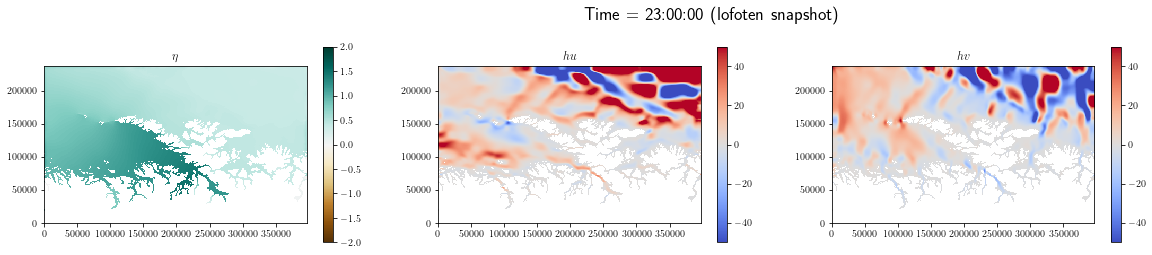

In [31]:
fig = plt.figure(figsize=(20,4))
_, _ = plotSolution(fig, sim_phi08_theta13, hu_max=50.0, eta_max=2, comment=case_info["name"]+" snapshot")


496 296


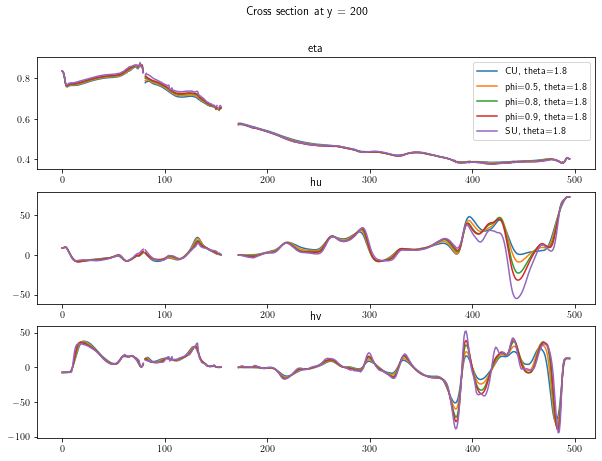

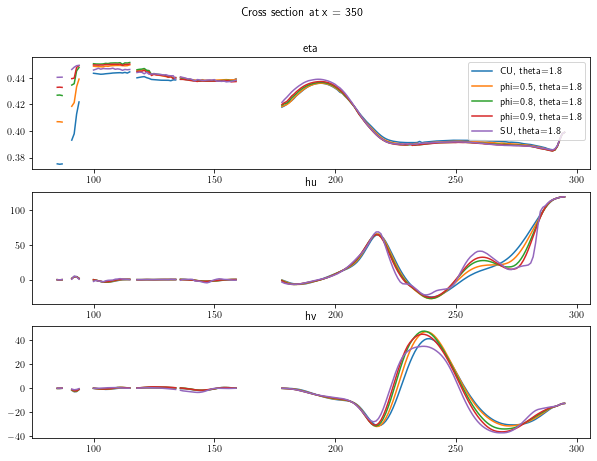

In [32]:
sim_labels = [
                #[sim_cu_theta1,  "CU, theta=1"    ],
                #[sim_cu_theta13,  "CU, theta=1.3" ],
                #[sim_phi08_theta13, "phi=0.8, theta=1.3"],
                #[sim_su_theta13,  "SU, theta=1.3" ],
                [sim_cu_theta18, "CU, theta=1.8"  ],
                [sim_phi05_theta18, "phi=0.5, theta=1.8"],
                [sim_phi08_theta18, "phi=0.8, theta=1.8"],
                [sim_phi09_theta18, "phi=0.9, theta=1.8"],
                [sim_su_theta18, "SU, theta=1.8"],
                #[sim_cu_theta2,  "CU, theta=2"    ],
                #[sim_phi09_theta2, "phi=0.9, theta=2"],
                #[sim_su_theta2,  "SU, theta=2"    ],

]

sims   = [None]*len(sim_labels)
labels = [None]*len(sim_labels)
for i in range(len(sim_labels)):
    sims[i]   = sim_labels[i][0]
    labels[i] = sim_labels[i][1]
    
plotCrossection(sims, labels, y=200)
plotCrossection(sims, labels, x=350)
print(sims[0].nx, sims[0].ny)

496 296


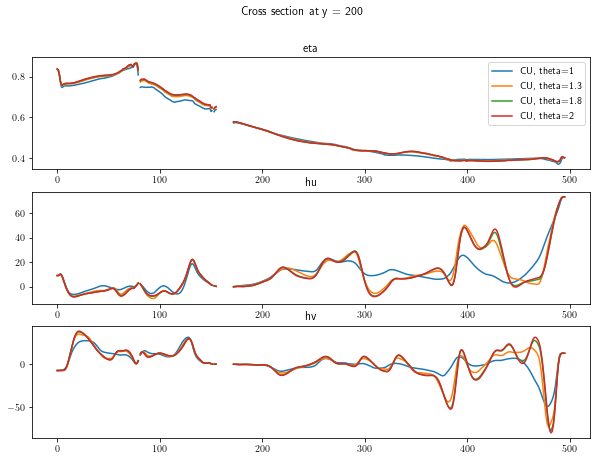

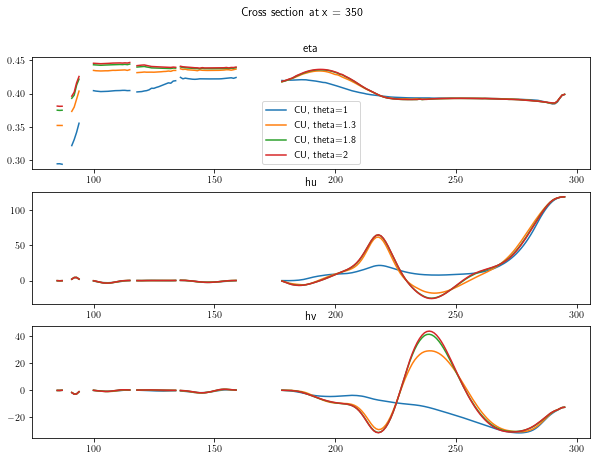

In [33]:
sim_labels = [
                [sim_cu_theta1,  "CU, theta=1"    ],
                [sim_cu_theta13,  "CU, theta=1.3" ],
                #[sim_phi08_theta13, "phi=0.8, theta=1.3"],
                #[sim_su_theta13,  "SU, theta=1.3" ],
                [sim_cu_theta18, "CU, theta=1.8"  ],
                #[sim_phi05_theta18, "phi=0.5, theta=1.8"],
                #[sim_phi08_theta18, "phi=0.8, theta=1.8"],
                #[sim_phi09_theta18, "phi=0.9, theta=1.8"],
                #[sim_su_theta18, "SU, theta=1.8"],
                [sim_cu_theta2,  "CU, theta=2"    ],
                #[sim_phi09_theta2, "phi=0.9, theta=2"],
                #[sim_su_theta2,  "SU, theta=2"    ],

]


sims   = [None]*len(sim_labels)
labels = [None]*len(sim_labels)
for i in range(len(sim_labels)):
    sims[i]   = sim_labels[i][0]
    labels[i] = sim_labels[i][1]
    
plotCrossection(sims, labels, y=200)
plotCrossection(sims, labels, x=350)
print(sims[0].nx, sims[0].ny)

496 296


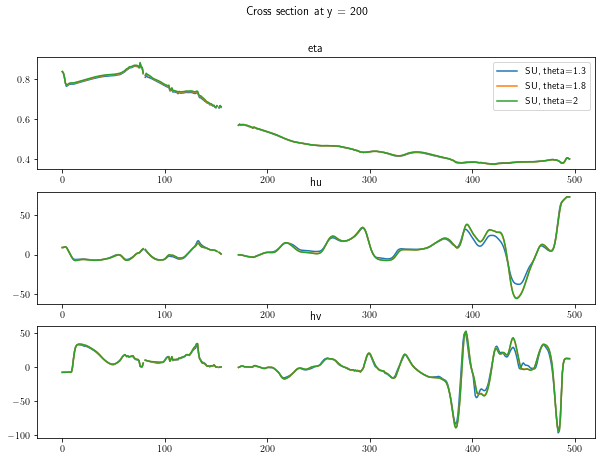

In [34]:
sim_labels = [
                #[sim_cu_theta1,  "CU, theta=1"    ],
                #[sim_cu_theta13,  "CU, theta=1.3" ],
                #[sim_phi08_theta13, "phi=0.8, theta=1.3"],
                [sim_su_theta13,  "SU, theta=1.3" ],
                #[sim_cu_theta18, "CU, theta=1.8"  ],
                #[sim_phi05_theta18, "phi=0.5, theta=1.8"],
                #[sim_phi08_theta18, "phi=0.8, theta=1.8"],
                #[sim_phi09_theta18, "phi=0.9, theta=1.8"],
                [sim_su_theta18, "SU, theta=1.8"],
                #[sim_cu_theta2,  "CU, theta=2"    ],
                #[sim_phi09_theta2, "phi=0.9, theta=2"],
                [sim_su_theta2,  "SU, theta=2"    ],

]


sims   = [None]*len(sim_labels)
labels = [None]*len(sim_labels)
for i in range(len(sim_labels)):
    sims[i]   = sim_labels[i][0]
    labels[i] = sim_labels[i][1]
    
plotCrossection(sims, labels, y=200)
plotCrossection(sims, labels, x=350)
print(sims[0].nx, sims[0].ny)

KP

In [35]:
from gpuocean.SWEsimulators import KP07

try: 
    sim_kp = KP07.KP07(gpu_ctx, dt=1.0,  **NetCDFInitialization.removeMetadata(data_args), flux_balancer=0.0, theta=2.0)
    sim_kp.step(23*3600)
except:
    print("KP07 is not implemented for NorKyst800 inputs")

KP07 is not implemented for NorKyst800 inputs


Exception ignored in: <function Simulator.__del__ at 0x7f45df738f80>
Traceback (most recent call last):
  File "/home/havahol/playground/gpuocean/havahol-gpuocean/src/gpuocean/SWEsimulators/Simulator.py", line 334, in __del__
    self.cleanUp()
  File "/home/havahol/playground/gpuocean/havahol-gpuocean/src/gpuocean/SWEsimulators/KP07.py", line 269, in cleanUp
    self.closeNetCDF()
  File "/home/havahol/playground/gpuocean/havahol-gpuocean/src/gpuocean/SWEsimulators/Simulator.py", line 347, in closeNetCDF
    if self.write_netcdf:
AttributeError: 'KP07' object has no attribute 'write_netcdf'


# Plot figure paper-style

In [56]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

folder = 'figs'
os.makedirs(folder, exist_ok=True)

def paperFig(sim, axs=None, velocity=True, zoom=0,
             interpolation="None", title=None, figsize=(7, 5.1),
             colorbar=True, fig=None,
             save_filename=None, savethis=False):
    
    # early preprint: figsize=(9, 3.4) 
    eta, hu, hv = sim.download(interior_domain_only=True)
    _, H_m = sim.downloadBathymetry(interior_domain_only=True)

    (ny, nx) = eta.shape
    # (296, 496)
    extent=np.array([0, nx*800, 0, ny*800]) / 1000
    
    zx0 = 80
    zx1 = 200
    zy0 = 80
    zy1 = 250
    if zoom == 2:
        zx0 = 30
        zx1 = 420
        zy0 = 20
        zy1 = 270
    if zoom > 0:
        eta = eta[zy0:zy1, zx0:zx1]
        hu =   hu[zy0:zy1, zx0:zx1]
        hv =   hv[zy0:zy1, zx0:zx1]
        H_m = H_m[zy0:zy1, zx0:zx1]
        extent = np.array([zx0, zx1, zy0, zy1])*800/1000

    if axs is None: 
        fig, axs = plt.subplots(1,1, figsize=figsize)
    axs = [axs]

    huv_max = max(np.max(np.abs(hu)), np.max(np.abs(hv)))/2
    
    
    
    V = PlotHelper.genVelocity(eta + H_m, hu, hv)
    V.mask = eta.mask
    
    # Colormaps
    v_cmap=plt.cm.Oranges
    hu_cmap=plt.cm.coolwarm

    # Set land color
    #land_color = 'xkcd:grey green' # 'grey'
    land_color = 'grey'
    v_cmap.set_bad(land_color, alpha=1.0)
    hu_cmap.set_bad(land_color, alpha=1.0)
    
    
    # Specifying hard vlims
    v_max = 0.42
    
    fontsize_title = 16
    fontsize_ticks = 12
    def addColorbar(ax, im, title):
        ax_divider = make_axes_locatable(ax)
        ax_cb = ax_divider.append_axes("right", size="5%", pad="5%")
        cbar = plt.colorbar(im, cax=ax_cb)#, orientation="vertical")
        #ax_cb.xaxis.set_ticks_position("top")
        #ax_cb.set_title(title, fontsize=fontsize)
        cbar.set_label(title, fontsize=fontsize_title)
        cbar.ax.tick_params(labelsize=fontsize_ticks)
    
    
    if velocity:
        hv_im = axs[0].imshow(V, interpolation=interpolation, origin='lower',
                            vmin=0, vmax=v_max, extent=extent, cmap=v_cmap)
        if colorbar:
            addColorbar(axs[0], hv_im, "particle velocity [m/s]")
    else:
        hv_im = axs[0].imshow(hu, interpolation=interpolation, origin='lower',
                            vmin=-huv_max, vmax=huv_max, extent=extent, cmap=hu_cmap)
        if colorbar:
            addColorbar(axs[0], hv_im, "hu [m^2/s]")

    axs[0].tick_params(axis='both', labelsize=fontsize_ticks)


    if title is not None:
        axs[0].set_title(title, fontsize=fontsize_title)
    #    axs[0].set_ylabel(main_title, labelpad=3, fontsize=fontsize)
    
    #if title is not None:
    #    plt.suptitle(r"\textbf{"+title+"}", y=1.1) #, fontsize=14)
    
        
    lon_freq = 2
    lat_freq = 1    
    if zoom > 0:
        cont_lon_case = axs[0].contour(spec_lon[zy0:zy1, zx0:zx1], levels = np.arange(0, 40, lon_freq), extent=extent, colors='k', alpha=0.2, linewidths=0.8)
        cont_lat_case = axs[0].contour(spec_lat[zy0:zy1, zx0:zx1], levels = np.arange(56,77, lat_freq), extent=extent, colors='k', alpha=0.2, linewidths=0.8)
    else:
        cont_lon_case = axs[0].contour(spec_lon, levels = np.arange(0, 40, lon_freq), extent=extent, colors='k', alpha=0.2, linewidths=0.8)
        cont_lat_case = axs[0].contour(spec_lat, levels = np.arange(56,77, lat_freq), extent=extent, colors='k', alpha=0.2, linewidths=0.8)

    if save_filename is not None and savethis:
        print(os.path.join(folder, save_filename), ' with lat-lon!')
        fig.savefig(os.path.join(folder, save_filename + ".png"), dpi=600, bbox_inches='tight')
        fig.savefig(os.path.join(folder, save_filename + ".pdf"), bbox_inches='tight')
        #plt.close()

/home/havahol/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Oranges"))
/home/havahol/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))


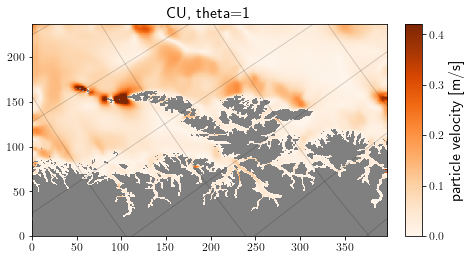

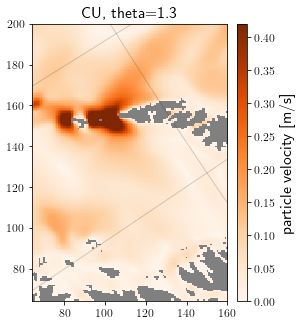

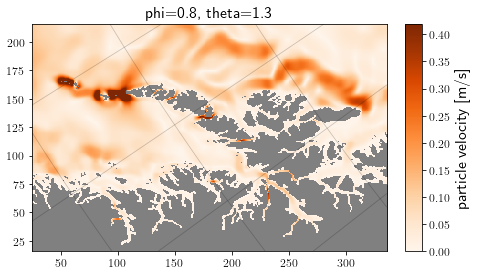

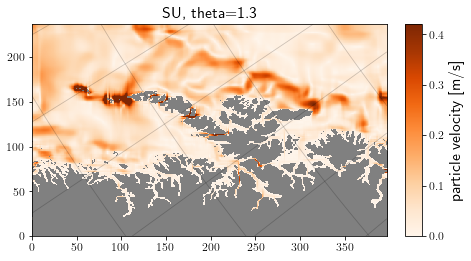

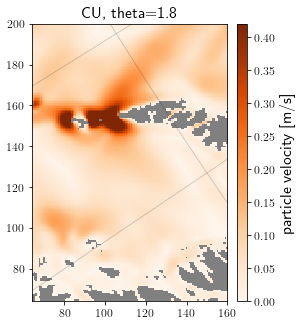

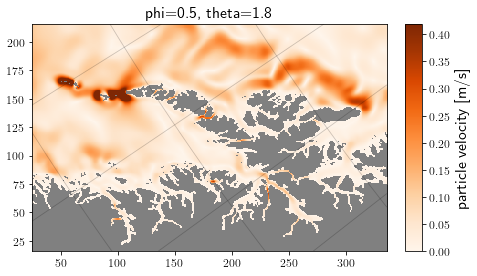

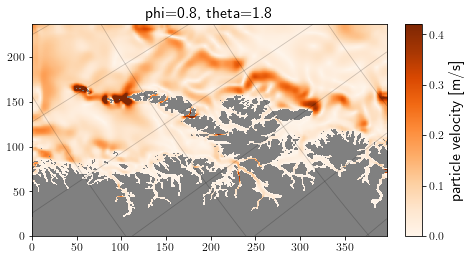

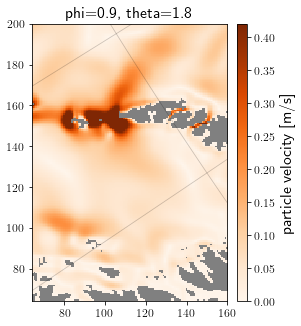

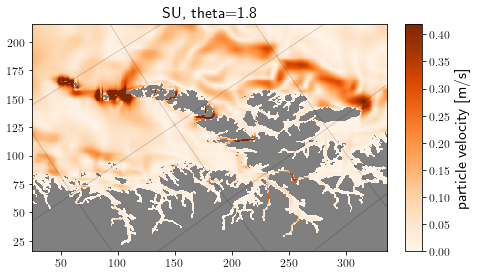

In [64]:
sim_labels = [
                [sim_cu_theta1,  "CU, theta=1"    ],
                [sim_cu_theta13,  "CU, theta=1.3" ],
                [sim_phi08_theta13, "phi=0.8, theta=1.3"],
                [sim_su_theta13,  "SU, theta=1.3" ],
                [sim_cu_theta18, "CU, theta=1.8"  ],
                [sim_phi05_theta18, "phi=0.5, theta=1.8"],
                [sim_phi08_theta18, "phi=0.8, theta=1.8"],
                [sim_phi09_theta18, "phi=0.9, theta=1.8"],
                [sim_su_theta18, "SU, theta=1.8"],
                [sim_cu_theta2,  "CU, theta=2"    ],
                [sim_phi09_theta2, "phi=0.9, theta=2"],
                [sim_su_theta2,  "SU, theta=2"    ],
]

for i in range(len(sim_labels)):
    paperFig(sim_labels[i][0], title=sim_labels[i][1], zoom=i%3)


/home/havahol/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Oranges"))
/home/havahol/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))


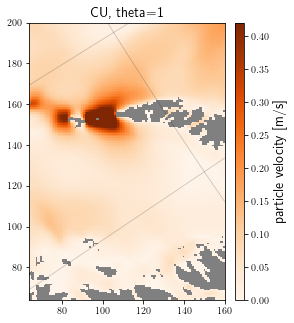

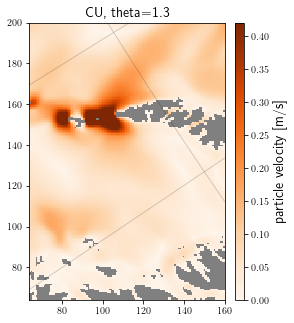

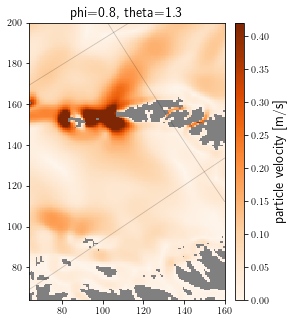

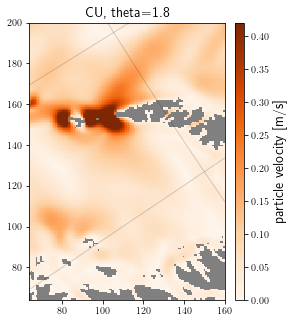

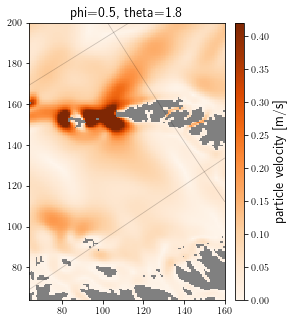

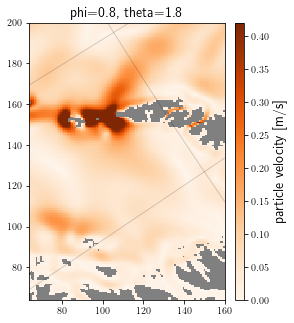

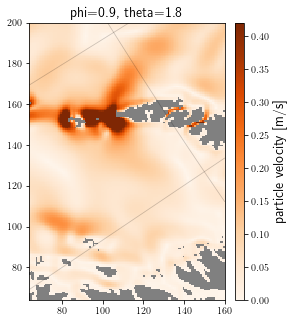

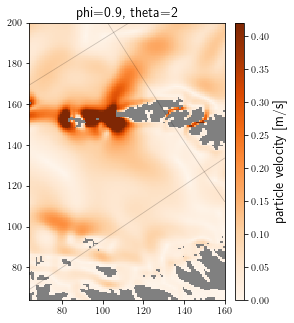

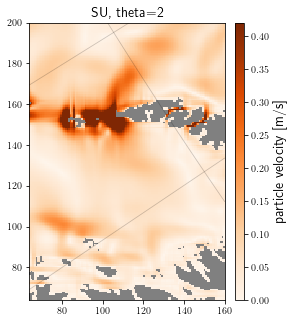

In [38]:
for i in range(len(sim_labels)):
    paperFig(sim_labels[i][0], title=sim_labels[i][1], zoom=True)


/home/havahol/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Oranges"))
/home/havahol/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))


figs/lovese_2plus4  with lat-lon!


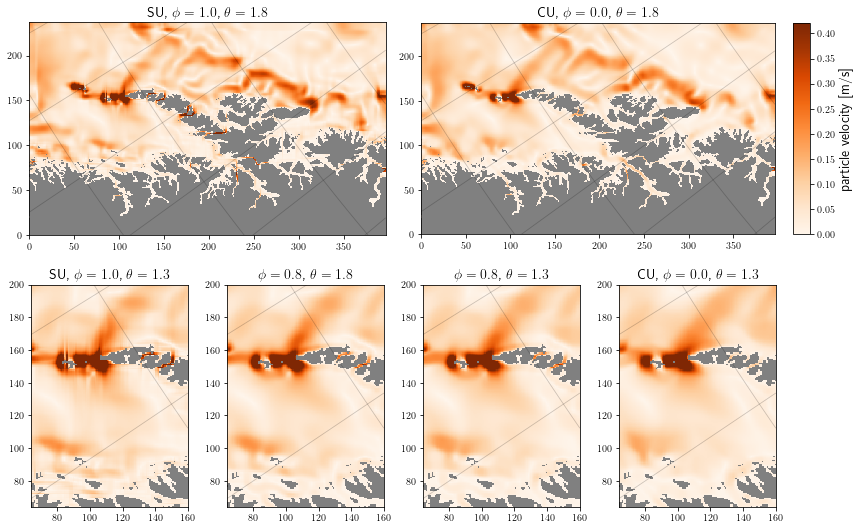

In [39]:
from matplotlib.gridspec import GridSpec

sim_labels = [
                [sim_cu_theta1,  r"CU, $\phi=0.0$, $\theta=1$"    ],
                [sim_cu_theta13,  r"CU, $\phi=0.0$, $\theta=1.3$" ],
                [sim_phi08_theta13, r"$\phi=0.8$, $\theta=1.3$"],
                [sim_su_theta13,  r"SU, $\phi=1.0$, $\theta=1.3$" ],
                [sim_cu_theta18, r"CU, $\phi=0.0$, $\theta=1.8$"  ],
                [sim_phi05_theta18, r"$\phi=0.5$, $\theta=1.8$"],
                [sim_phi08_theta18, r"$\phi=0.8$, $\theta=1.8$"],
                [sim_phi09_theta18, r"$\phi=0.9$, $\theta=1.8$"],
                [sim_su_theta18, r"SU, $\phi=1.0$, $\theta=1.8$"],
                [sim_cu_theta2,  r"CU, $\phi=0.0$, $\theta=2$"    ],
                [sim_phi09_theta2, r"$\phi=0.9$, $\theta=2$"],
                [sim_su_theta2,  r"SU, $\phi=1.0$, $\theta=2$"    ],
]

fig = plt.figure(figsize=(14,9))
#gs = GridSpec(2, 4, figure=fig)
#ax_big1 = fig.add_subplot(gs[0,:2])
#ax_big2 = fig.add_subplot(gs[0,2:])
#ax_small1 = fig.add_subplot(gs[1,0])
#ax_small2 = fig.add_subplot(gs[1,1])
#ax_small3 = fig.add_subplot(gs[1,2])
#ax_small4 = fig.add_subplot(gs[1,3])

gs = GridSpec(2, 48, figure=fig)
ax_big1 = fig.add_subplot(gs[0,:22])
ax_big2 = fig.add_subplot(gs[0,24:])
ax_small1 = fig.add_subplot(gs[1,:10])
ax_small2 = fig.add_subplot(gs[1,12:22])
ax_small3 = fig.add_subplot(gs[1,24:34])
ax_small4 = fig.add_subplot(gs[1,36:46])

paperFig(sim_labels[8][0], title=sim_labels[8][1], zoom=False, axs=ax_big1, colorbar=False)
paperFig(sim_labels[4][0], title=sim_labels[4][1], zoom=False, axs=ax_big2)

paperFig(sim_labels[3][0], title=sim_labels[3][1], zoom=True, axs=ax_small1, colorbar=False)
paperFig(sim_labels[6][0], title=sim_labels[6][1], zoom=True, axs=ax_small2, colorbar=False)
paperFig(sim_labels[2][0], title=sim_labels[2][1], zoom=True, axs=ax_small3, colorbar=False)
paperFig(sim_labels[1][0], title=sim_labels[1][1], zoom=True, axs=ax_small4, colorbar=False, save_filename="lovese_2plus4", savethis=True, fig=fig)



In [67]:
fig = plt.figure(figsize=(14,9))
#gs = GridSpec(2, 4, figure=fig)
#ax_big1 = fig.add_subplot(gs[0,:2])
#ax_big2 = fig.add_subplot(gs[0,2:])
#ax_small1 = fig.add_subplot(gs[1,0])
#ax_small2 = fig.add_subplot(gs[1,1])
#ax_small3 = fig.add_subplot(gs[1,2])
#ax_small4 = fig.add_subplot(gs[1,3])

gs = GridSpec(2, 48, figure=fig)
ax_big1 = fig.add_subplot(gs[0,:22])
ax_big2 = fig.add_subplot(gs[0,24:])
ax_big3 = fig.add_subplot(gs[1,:22])
ax_big4 = fig.add_subplot(gs[1,24:46])

paperFig(sim_labels[8][0], title=sim_labels[8][1], axs=ax_big1, zoom=2, colorbar=False)
paperFig(sim_labels[4][0], title=sim_labels[4][1], axs=ax_big2, zoom=2)
paperFig(sim_labels[2][0], title=sim_labels[2][1], axs=ax_big3, zoom=2, colorbar=False)
paperFig(sim_labels[6][0], title=sim_labels[6][1], axs=ax_big4, zoom=2, colorbar=False, save_filename="lovese_2x2", savethis=True, fig=fig)

sims   = [None]*4
labels = [None]*4
for i, j in zip(range(4), [8, 4, 2, 6]):
    sims[i]   = sim_labels[j][0]
    labels[i] = sim_labels[j][1]
    
plotCrossection(sims, labels, y=200)
plotCrossection(sims, labels, x=350)


/home/havahol/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Oranges"))
/home/havahol/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))


figs/lovese_2x2  with lat-lon!


In [41]:
for i,j in zip(range(5), ["a", "b", "g", "g", ","]):
    print(i, j)

0 a
1 b
2 g
3 g
4 ,
